CFL condition satisfied.
Solving linear variational problem.


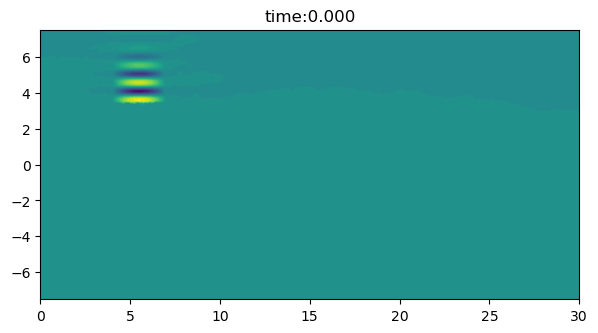

Solving linear variational problem.


KeyboardInterrupt: 

In [1]:
# Simulation for the ocean wave with viscous-elastic sea bed
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import meshio
from math import sin, cos, pi
import time

t_start = time.time()

# Simulation parameters
Lx, Ly = 30, 15                               # Domain size (30 by 15 non-dimensional units)
delta = 0.8                                  # Thickness of the boundary
resolution = 120                              # Mesh resolution
T = 2.5                                       # Time period for wave oscillations
g = 9.81                                      # Gravitational acceleration
rho = 1025                                    # Density of water
kh = 0.1                                      # Shallow water condition kh << 1
omega = 2 * np.pi / T                         # Angular frequency
h = g * kh ** 2 / omega ** 2                  # Height of the water surface over the sea bed
c = np.sqrt(g * h)                            # Characteristic speed
k = omega / c                                 # Wave number
k_star = 1e5                                  # Stiffness coefficient of seabed
b_star = 1e2                                  # Damping coefficient of seabed

save_file = 0                                 # If 1, save the data
#xdmf_phi = XDMFFile("phi_bending.xdmf")            # The file to save the velocity potential field
#timeseries_phi = TimeSeries("phi_series_bending")   # The file to save the velocity potential field
xdmf_phi_R = XDMFFile("phi_R_bending.xdmf")
timeseries_phi_R = TimeSeries("phi_R_series_bending")
width = 2                                   # Width of the sponge layer at the outlet
width_y = 2                                 # Width of the sponge layer at the top and the bottom
inflow_length = 4                             # Length of the inflow area
inflow_height = 3                             # Width of the inflow area
inflow_c = 5.5
L = 1.5                                         # Width of the wave guide
# Simulation domain configuration and generate mesh

channel = Rectangle(Point(0, -Ly/2), Point(Lx, Ly/2))
domain = channel
mesh = generate_mesh(domain, resolution)

cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
cell_markers.set_all(False)
for cell in cells(mesh):
    p = cell.midpoint()
    if p.x() < 7 and p.x() > 4 and p.y() > 3.5:
        cell_markers[cell] = True
mesh = refine(mesh, cell_markers, redistribute=True)

# Functionspace and functions

V = FunctionSpace(mesh, 'P', 2)
V_R = FunctionSpace(mesh, 'P', 2)
V_I = FunctionSpace(mesh, 'P', 2)
W = FunctionSpace(mesh, MixedElement([V_R.ufl_element(), V_I.ufl_element()]))
psi = TestFunction(W)      # Test function for the velocity potential
psi_R, psi_I = split(psi)
phi_p = TrialFunction(W)   # Phi at time step (n+1)
phi_p_R, phi_p_I = split(phi_p)
phi_n = Function(W)        # Phi at time step n
phi_n_R, phi_n_I = split(phi_n)
phi_m = Function(W)        # Phi at time step (n-1)
phi_m_R, phi_m_I = split(phi_m)
phi = Function(W)          # Function to store the solution

# Define boundaries

class InflowBoundary(SubDomain):
    def inside(self,x,on_boundary):
        a = inflow_c - 0.5 * inflow_height
        b = inflow_c + 0.5 * inflow_height
        return a < x[0] and x[0] < b and x[1] > 3.5
    
class InflowBoundary_nowave(SubDomain):
    def inside(self,x,on_boundary):
        return 0 < x[0] and x[0] < inflow_length and (-1.5 > x[1] or x[1] > 1.5)

class SpongeLayer(SubDomain):
    def inside(self,x,on_boundary):
        return x[0] > (Lx - width) and x[0] < Lx

class TopFlankSponge(SubDomain):
    def inside(self,x,on_boundary):
        return x[1] > (0.5 * Ly - width_y) and x[1] < (0.5 * Ly)

class BottomFlankSponge(SubDomain):
    def inside(self,x,on_boundary):
        return x[1] < (-0.5 * Ly + width_y) and x[1] > (-0.5 * Ly)

class WaveGuide(SubDomain):
    def inside(self,x,on_boundary):
        return x[0] >= 10 and x[1] >= -2.5 and x[1] <= 0.5

class BendingArea(SubDomain):
    def inside(self,x,on_boundary):
        dis = np.sqrt((x[0] - 10) ** 2 + (x[1] - 3.5) ** 2)
        return x[0] <= 10 and x[1] <= 3.5 and dis >= 3 and dis <= 6  

boundary_markers = MeshFunction("size_t",mesh,mesh.topology().dim()-1)
boundary_markers.set_all(0)
inflow_wave = InflowBoundary()
inflow_wave.mark(boundary_markers, 1)
inflow_nowave = InflowBoundary_nowave()
inflow_nowave.mark(boundary_markers, 2)
sponge = SpongeLayer()
sponge.mark(boundary_markers,3)
top = TopFlankSponge()
top.mark(boundary_markers,4)
bottom = BottomFlankSponge()
bottom.mark(boundary_markers,5)
waveguide = WaveGuide()
waveguide.mark(boundary_markers,6)
bendingarea = BendingArea()
bendingarea.mark(boundary_markers,7)
# outflow = 'near(x[0],30)'
# walls = 'near(x[1],-7.5)||near(x[1],7.5)'

# Boundary conditions 
# In FEniCS, the Neumann condition which represents artificial absorbing is the default, so it's not assigned explicitly.

inflow_profile = ('A * cos(k * (7.5 - x[1]) - omega * t) * cos(pi * (x[0] - inflow_c) / inflow_height) * 0.5 * (1 + tanh(-x[1] + 5.5)) ')

inflow_f = Expression(inflow_profile, A=1.0, alpha=0.5, k=k, omega=omega, t=0, inflow_c = inflow_c, inflow_length=inflow_length, inflow_height=inflow_height, degree=2)
bc_inlet_R = DirichletBC(W.sub(0), inflow_f, inflow_wave)
bc_inlet_I = DirichletBC(W.sub(1), Constant(0.0),inflow_wave)
#bc_inlet1 = DirichletBC(V, Constant(0.0), inflow_nowave)
# bc_top_bottom = DirichletBC(V, Constant(0.0), walls)
# bc_phi = [bc_inlet, bc_inlet1, bc_top_bottom]
bc_phi = [bc_inlet_R, bc_inlet_I]


# Define the effective gravity file g_eff
# g_eff = alpha - beta * i, wheres i is the imaginary unit
C_alpha = g * (1 + rho * g * k_star / (k_star ** 2 + b_star ** 2 * omega ** 2))
class AlphaExpression(UserExpression):
    def __init__(self, C, delta, L, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.delta = delta
        self.L = L
    
    def eval(self, values, x):
        r = np.sqrt((x[0] - 10) ** 2 + (x[1] - 3.5) ** 2)
        
        if x[0] <= 10 and x[1] <= 3.5 and r >= 3 and r <= 6:
            values[0] = self.C / (1 - self.delta * pow((r - 4.5), 2) / pow(L, 2))
        
        elif x[0] > 10 and x[1] > -2.5 and x[1] < 0.5:
            values[0] = self.C / (1 - self.delta * pow((x[1] + 1), 2) / pow(L, 2))

        elif (r > 6 and x[0] > 4 and x[1] > -2.5 and x[0] < 10 and x[1] < 3.5) or (x[1] > -3 and x[1] < - 2.5 and x[0] > 4 and x[0] < 12):
            values[0] = 60

        elif (r < 3 and x[1] < 3.5 and x[0] < 10) or (x[0] > 10 and x[0] < 12 and x[1] > 0.5 and x[1] < 3.5):
            values[0] = 50
        else:
            values[0] = 9.81
    
    def value_shape(self):
        return ()  # Scalar expression
alpha_exp = AlphaExpression(C=C_alpha, delta=delta, L=L, degree=2)
alpha = project(alpha_exp, V)

C_beta = g * (rho * g * b_star * omega / (k_star ** 2 + b_star ** 2 * omega ** 2))
class BetaExpression(UserExpression):
    def __init__(self, C, delta, L, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.delta = delta
        self.L = L
    
    def eval(self, values, x):
        r = np.sqrt((x[0] - 10) ** 2 + (x[1] - 3.5) ** 2)
        
        if x[0] <= 10 and x[1] <= 3.5 and r >= 3 and r <= 6:
            values[0] = self.C / (1 - self.delta * pow((r - 4.5), 2) / pow(L, 2))
        
        elif x[0] > 10 and x[1] > -2.5 and x[1] < 0.5:
            values[0] = self.C / (1 - self.delta * pow((x[1] + 1), 2) / pow(L, 2))
        else:
            values[0] = 0
    
    def value_shape(self):
        return ()  # Scalar expression
beta_exp = BetaExpression(C=C_beta, delta=delta, L=L, degree=2)
beta = project(beta_exp, V)






n = FacetNormal(mesh) # Outward normal vector on the facets (boundaries) of the mesh
dt = T / 400 # Length of each time step

# Check the CFL condition

delta_x = mesh.hmin()
delta_t = dt
if c * delta_t <= delta_x:
    print("CFL condition satisfied.")
else:
    print("CFD condition not satisfied. c:", c, "delta_t:", delta_t, "delta_x:", delta_x)


# Variational form to be solved

F_R = (phi_p_R * psi_R / dt ** 2 - 2 * phi_n_R * psi_R / dt ** 2 + phi_m_R * psi_R / dt ** 2) * dx\
      + 0.5 * dot(grad(psi_R * alpha), h * grad(phi_p_R)) * dx\
      + 0.5 * dot(grad(psi_R * alpha), h * grad(phi_n_R)) * dx\
      + 0.5 * dot(grad(psi_R * beta), h * grad(phi_p_I)) * dx\
      + 0.5 * dot(grad(psi_R * beta), h * grad(phi_n_I)) * dx

F_I = (phi_p_I * psi_I / dt ** 2 - 2 * phi_n_I * psi_I / dt **2 + phi_m_I * psi_I / dt ** 2) * dx\
      + 0.5 * dot(grad(psi_I * alpha), h * grad(phi_p_I)) * dx\
      + 0.5 * dot(grad(psi_I * alpha), h * grad(phi_n_I)) * dx\
      - 0.5 * dot(grad(psi_I * beta), h * grad(phi_p_R)) * dx\
      - 0.5 * dot(grad(psi_I * beta), h * grad(phi_n_R)) * dx

F = F_R + F_I

a = lhs(F)
L = rhs(F)



# If the boundary conditions are dependent on time, update the boundary conditions

def update_bc(new_t):
    inflow_f.t = new_t
    bc_inlet_R = DirichletBC(W.sub(0), inflow_f, inflow_wave)
    bc_phi = [bc_inlet_R, bc_inlet_I]

# Relaxation factors for the boundary layers

def relaxation_factor(x,Lx=Lx,width=width,eta=5):
    norm = np.abs(np.tanh(eta * (Lx - width - (Lx - 0.5 * width))))

    if x > (Lx - width):
        return 0.5 * (1 + np.tanh(eta * (x - (Lx - 0.5 * width)))/norm)
    elif x < width:
        return 0.5 * (1 - np.tanh(eta * (x - 0.5 * width))/norm)
    else:
        return 0.0
    

def relaxation_factor_y(y,Ly=Ly,width_y=width_y,eta=5):
    if y < (width_y - 0.5 * Ly):
        return 0.5 * (1 -np.tanh(eta * (y + (0.5 * Ly - 0.5 * width_y))))
    else:
        return 0

t = 0
n = 0
while t < 40 * T:
    update_bc(t)
    solve(a==L, phi, bc_phi)

    

    phi_array = phi.vector().get_local()
    coords = W.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))
    
    
    for i,coord in enumerate(coords):
        x = coord[0]
        y = coord[1]
        relaxation_factor_value = relaxation_factor(x)
        relaxation_y = relaxation_factor_y(y)
        phi_array[i] = relaxation_factor_value * 0.0 + (1 - relaxation_factor_value) * phi_array[i]
        phi_array[i] = relaxation_y * 0.0 + (1 - relaxation_y) * phi_array[i]
    phi.vector().set_local(phi_array)

    phi_R, phi_I = phi.split(deepcopy=True)

    
    phi_m.assign(phi_n)
    phi_n.assign(phi)

    
    if save_file == 1:
        #xdmf_phi.write(phi,t)
        #timeseries_phi.store(phi.vector(),t)
        xdmf_phi_R.write(phi_R,t)
        timeseries_phi_R.store(phi_R.vector(),t)
        
    if n % 20 == 0:
        
        plt.figure(figsize=(8,3.5))
        plot(phi_R,title=f"time:{t:.3f}")
        plt.show()

    
        
    t += dt
    n += 1

# Visualize

plt.clf()
phi_array = phi.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(), ))
plt.figure(figsize = (8, 3.5))
plt.tripcolor(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(), phi_array, shading="gouraud", cmap="jet")
plt.colorbar()

t_end = time.time()
t_total = t_end - t_start




print("The total time cost:", t_total)

MovieWriter imagemagick unavailable; using Pillow instead.


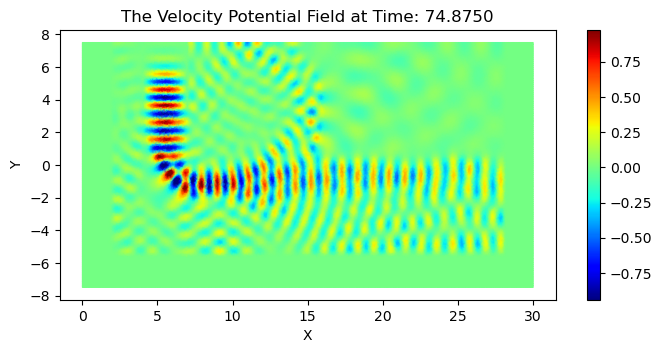

In [7]:
from matplotlib.animation import FuncAnimation
phi_111 = Function(W)
phi_R, phi_I = phi_111.split(deepcopy=True)
fig, ax = plt.subplots(figsize=(8, 3.5))

timeseries_phi_R.retrieve(phi_R.vector(),0)





# Initialize a tripcolor plot (without data)
phi_array = phi_R.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(),))
tc = ax.tripcolor(
    mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(),
    phi_array, shading="gouraud", cmap="jet"
)

# Set up colorbar and labels
fig.colorbar(tc, ax=ax)
ax.set_xlabel("X")
ax.set_ylabel("Y")
title = ax.set_title("")

# Update function for animation
def update(frame):
    delta_t = 75/600
    t = frame * delta_t
    timeseries_phi_R.retrieve(phi_R.vector(), t)
    
    phi_array = phi_R.compute_vertex_values(mesh).reshape((mesh.num_vertices(),))
    tc.set_array(phi_array)  # Update the color data
    title.set_text(f"The Velocity Potential Field at Time: {t:.4f}")

    return tc, title

# Create animation
ani = FuncAnimation(fig, update, frames=600, interval=20, blit=True)

# Save as a GIF
ani.save('STDBending.gif', writer='imagemagick', fps=30)

plt.show()

6.4388856439318936

In [ ]:
while t < 48 * T:
    update_bc(t)
    solve(a==L, phi, bc_phi)

    

    phi_array = phi.vector().get_local()
    coords = V.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))
    
    
    for i,coord in enumerate(coords):
        x = coord[0]
        y = coord[1]
        relaxation_factor_value = relaxation_factor(x)
        relaxation_y = relaxation_factor_y(y)
        #phi_array[i] = relaxation_factor_value * 0.0 + (1 - relaxation_factor_value) * phi_array[i]
        phi_array[i] = relaxation_y * 0.0 + (1 - relaxation_y) * phi_array[i]
    phi.vector().set_local(phi_array)

    
    
    phi_m.assign(phi_n)
    phi_n.assign(phi)

    phi_R, phi_I = phi.split(deepcopy=True)
    
    if save_file == 1:
        xdmf_phi.write(phi,t)
        timeseries_phi.store(phi.vector(),t)
        xdmf_phi_R.write(phi_R,t)
        timeseries_phi_R.store(phi_R.vector(),t)
        
    if n % 20 == 0:
        
        plt.figure(figsize=(8,3.5))
        plot(phi_R,title=f"time:{t:.3f}")
        plt.show()



<Figure size 640x480 with 0 Axes>

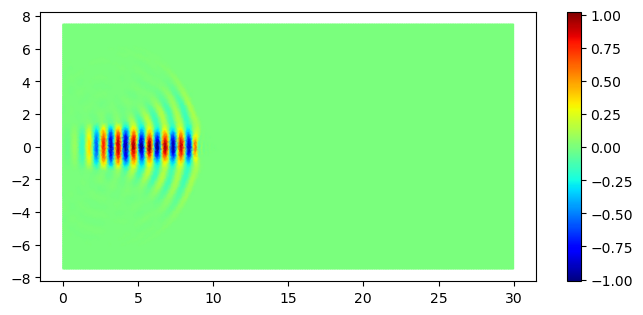

In [48]:
phi_R, phi_I = phi.split(deepcopy=True)
plt.clf()
phi_array = phi_R.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(), ))
plt.figure(figsize = (8, 3.5))
plt.tripcolor(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(), phi_array, shading="gouraud", cmap="jet")
plt.colorbar()

MovieWriter imagemagick unavailable; using Pillow instead.


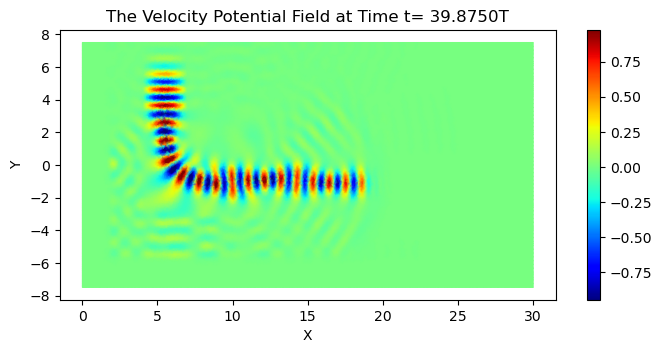

In [2]:
from matplotlib.animation import FuncAnimation
phi_111 = Function(W)
phi_R, phi_I = phi_111.split(deepcopy=True)
fig, ax = plt.subplots(figsize=(8, 3.5))

timeseries_phi_R.retrieve(phi_R.vector(),0)


    

# Initialize a tripcolor plot (without data)
phi_array = phi_R.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(),))
tc = ax.tripcolor(
    mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(),
    phi_array, shading="gouraud", cmap="jet"
)

# Set up colorbar and labels
fig.colorbar(tc, ax=ax)
ax.set_xlabel("X")
ax.set_ylabel("Y")
title = ax.set_title("")

# Update function for animation
def update(frame):
    delta_t = 70/560
    t = frame * delta_t
    timeseries_phi_R.retrieve(phi_R.vector(), t)
    t_non = t / T
    
    phi_array = phi_R.compute_vertex_values(mesh).reshape((mesh.num_vertices(),))
    tc.set_array(phi_array)  # Update the color data
    title.set_text(f"The Velocity Potential Field at Time t= {t:.4f}T")

    return tc, title

# Create animation
ani = FuncAnimation(fig, update, frames=320, interval=20, blit=True)

# Save as a GIF
ani.save('Bending11.20.gif', writer='imagemagick', fps=30)

plt.show()

<Figure size 640x480 with 0 Axes>

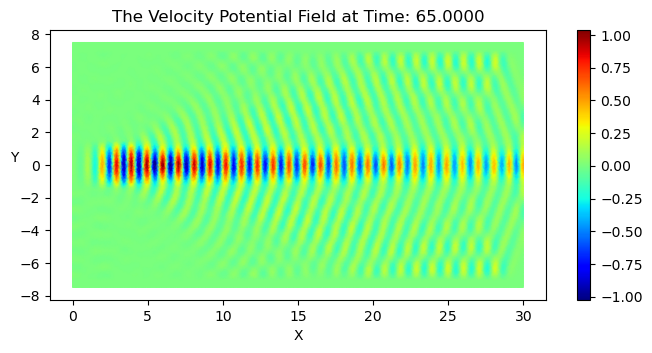

In [20]:
phi_R = Function(V_R)
timeseries_phi_R.retrieve(phi_R.vector(),65)

plt.clf()
phi_array = phi_R.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(), ))
plt.figure(figsize = (8, 3.5))
plt.xlabel("X")
plt.ylabel("Y",rotation=0)
plt.title("The Velocity Potential Field at Time: 65.0000")
plt.tripcolor(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(), phi_array, shading="gouraud", cmap="jet")
plt.colorbar()
plt.savefig("VESeabed.png",dpi=700)

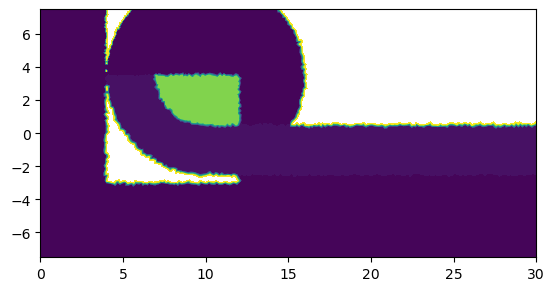

In [5]:
plot(alpha)

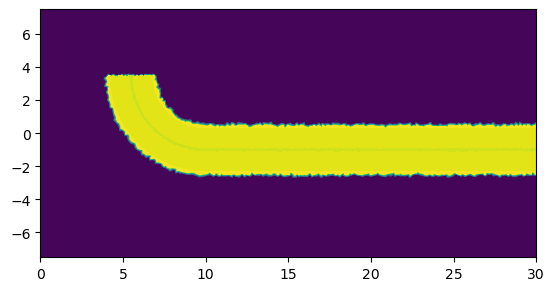

In [6]:
plot(beta)

<Figure size 640x480 with 0 Axes>

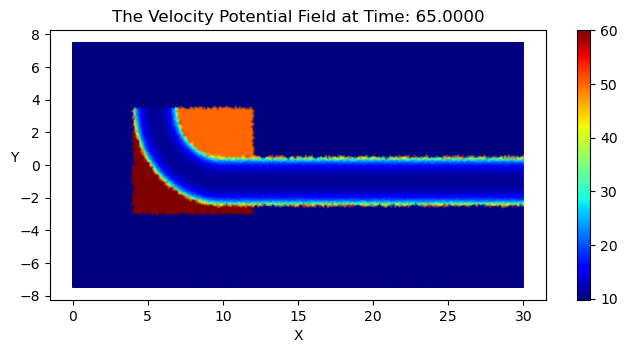

In [11]:
plt.clf()
phi_array = alpha.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(), ))
plt.figure(figsize = (8, 3.5))
plt.xlabel("X")
plt.ylabel("Y",rotation=0)
plt.title("The Velocity Potential Field at Time: 65.0000")
plt.tripcolor(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(), phi_array, shading="gouraud", cmap="jet")
plt.colorbar()